# Computing metrics



The objective of this notebook is to see if we could have meetric to evaluate annotations.

The mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample.
The Silhouette Coefficient for a sample is (b - a) / max(a, b) => 1 is best value; -1 is overallping clusters; 




It has been shown that the silhouette score can vary depending on the number of axis selected (for example in Aparicio et al. 2020).
However here as a first evaluation, we used all axis. A large number can sometimes leads to slighly lower scores; however it seems to give a more stable one.




<!-- Evaluate ARI to compare annotation (like auto_annot report).

See other possible metrics ?-> Luecken et al.
--> 



We compare across all datasets of the manuscript. 


In [1]:

#load libraries
import besca as bc
import scanpy as sc
import random

random.seed(1)

In [2]:
import sys
#sys.path

# Implementation


Whereas evaluating cell type annotation for single-cell  analyses, we proposed to observe simple metrics for Besca’s module *Sig-annot*. 

Here, we use the **silhouette score** (1) to show that our biological annotation does capture similar cells, as a silhouette score above 0 _ and closer to 1 _ indicates that the variance intra-cluster is lower than the variance between clusters.


For all datasets presented in the main manuscript, we compute the **average silhouette score** using the scikit implementation. The euclidean distance was computed on the umap space. 
It has been shown that the silhouette score can vary depending on the number of axis selected (2).
A large number can sometimes lead to slightly lower scores; but this seems to give a more stable one.

Hence, here as a first evaluation, we used all remaining axis (50). This score was computed on the **dblabel** assignment, but also, taking advantage of the hierarchical structure of *sig-annot* on the **level 2 cell identities**.
Finally, we computed a score for a **random assignment** of the same labels and with the **author annotation** when available (this is done below).


This is done for all datasets of the manuscript  **except** Lee et all which annotations contains labels not in the nomenclature (eg. IgA plasma cell). Lee et all is done manually below



(1) Rousseeuw, P. J. (1987). Silhouettes: a graphical aid to the interpretation and validation of cluster analysis. Journal of computational and applied mathematics, 20, 53-65.

(2) Aparicio, L., Bordyuh, M., Blumberg, A. J., & Rabadan, R. (2020). A random matrix theory approach to denoise single-cell data. Patterns, 1(3), 100035.

In [3]:
#FUNCTION BELOW TO BE INCORPORATE IN THE NEXT BESCA RELEASES.

import seaborn as sns
import pandas as pd
import sklearn
import anndata

import matplotlib
import pkg_resources

from dataclasses import dataclass

@dataclass
class silhouette_in :
    #sample_values : pd.DataFrame
    show_samples : matplotlib.axes # acces is obj.show_samples.get_figure()
    averaged : float
        

@dataclass
class silhouette_DATA_all :
    dblabel_res : silhouette_in 
    dblabel_l2_res : silhouette_in 
    dblabel_random  : silhouette_in
   
        
        
    
def silhouette_computation (adata: anndata.AnnData, cluster: str = 'dblabel', emb: str = 'X_umap', verbose : bool = True) -> silhouette_in :    
    """ Compute the average and per cell (ie samples) silhouette score for 
    the cluster label (should be present in dataobs) (level 3 annotation), computed level 2 annotation and a random cell assignbation.
    Return a silhouette_in object

    parameters
    ---------
    adata:  anndata.AnnData
    cluster: 'str'
      clustering to evaluate (should be a column in adata.obs)
    emb: str
        embedding to use for computing the euclidian distance.
        should be a key of  obsm
        
    returns
    -------
    silhouette_in dataclass object 
    
     Example
    -------
    >>> import besca as bc
    >>> adata = bc.datasets.pbmc3k_processed()
    >>> vv = silhouette_computation ()
    >>> vv.show_samples.get_figure()
    
    """
    silhouette_avg = sklearn.metrics.silhouette_score(adata.obsm[emb], adata.obs.get(cluster))
    sample_silhouette_values = sklearn.metrics.silhouette_samples(adata.obsm[emb], adata.obs.get(cluster))
    if verbose:
        print("The average silhouette_score is :", silhouette_avg)
    cluster_labels= adata.obs.get(cluster).unique()
    n_clusters = len( cluster_labels)
    ith_value = {}
    size_cluster  = {}
    for i in range(n_clusters):
# Aggregate the silhouette scores for samples belonging to
# cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[adata.obs.get(cluster) == cluster_labels[i]]#sample_silhouette_values[i]
#ith_cluster_silhouette_values.sort()
        ith_value[cluster_labels[i]] = ( ith_cluster_silhouette_values )
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        size_cluster[ cluster_labels[i]] = size_cluster_i

    long_df_silhouette  = pd.concat(pd.DataFrame({'label':k, 'silhouette':v}) for k, v in ith_value.items())
    # TODO ADD PROPER TITLE/ AXIS/ MEAN OVERALL  and mean per label ?
    ax1 = sns.violinplot( y=long_df_silhouette["label"], x=long_df_silhouette["silhouette"], scale = 'count')
    silhouette_results = silhouette_in(#sample_silhouette_values,
        ax1 , silhouette_avg  )
    matplotlib.pyplot.close() # Avoid plooting in function; bad practice

    return ( silhouette_results  )

    
def change_level(adata: anndata.AnnData) -> anndata.AnnData : 
    level = 2 
    new_cnames = bc.tl.sig.obtain_new_label(
        nomenclature_file=pkg_resources.resource_filename('besca', 'datasets/nomenclature/CellTypes_v1.tsv'), 
        cnames=list(adata.obs['dblabel'].cat.categories), 
        reference_label='dblabel', 
        new_label='dblabel', 
        new_level=level )
    adata.obs['dblabel_l' + str(level)] = bc.tl.sig.add_anno(adata, new_cnames, 'new_label', 'dblabel')
    return( adata)




def silhouette_metrics ( adata: anndata.AnnData, cluster:str = 'dblabel', emb:str = 'X_umap') -> silhouette_DATA_all :    
    """ Compute for the dblabel, level 2 label and a radom assignation the silhouette information
    Return a dataClasse silhouette_DATA_all

    parameters
    ---------
    adata:  anndata.AnnData
    cluster: 'str'
      clustering to evaluate (should be a column in adata.obs and processable through change_level)
    emb: str
        embedding to use for computing the euclidian distance.
        should be a key of  obsm
        
    returns
    -------
    silhouette_DATA_all  dataclass object 
    
     Example
    -------
    >>> import besca as bc
    >>> adata = bc.datasets.pbmc3k_processed()
    >>> vv = silhouette_metrics()
    >>> vv.dblabel_res.show_samples.get_figure()
    
    """
    output_dblabel = silhouette_computation( adata, cluster = cluster , emb = emb, verbose=False)
    adata = change_level(adata)
    output_l2 = silhouette_computation( adata, cluster = 'dblabel_l2' , emb = emb, verbose=False)
    adata.obs[ 'random_db']  = list(adata.obs['dblabel'].sample(frac=1))
    output_rand = silhouette_computation( adata, cluster = 'random_db' , emb = emb, verbose=False)
    obj_all = silhouette_DATA_all(dblabel_res = output_dblabel,
                                  dblabel_l2_res = output_l2,
                                  dblabel_random =  output_rand)
    return obj_all
    

# Obtaining results

In [4]:


def read_kotliarov():
    adata = bc.datasets.Kotliarov2020_processed()
    adata.obs['dblabel'] = adata.obs.get('celltype3')
    return adata

data_names = ['PMBC3k',
              'Granja2019', 
              'Kotliarov2020', 
              'Smilie2019', 
              'Martin2019', 
              'Haber2017', 
             # 'Lee2020',
              'Segerstolpe2016',
              'Peng2019',
              'Baron2016'
             ]


data_access = [
    bc.datasets.pbmc3k_processed,
    bc.datasets.Granja2019_processed, 
    read_kotliarov, 
    bc.datasets.Smillie2019_processed, 
    bc.datasets.Martin2019_processed,
    bc.datasets.Haber2017_processed, 
    # bc.datasets.Lee2020_processed,
    bc.datasets.Segerstolpe2016_processed, 
    bc.datasets.Peng2019_processed, 
    bc.datasets.Baron2016_processed
]
#result_Silhouette = pd.DataFrame()

data_info = pd.DataFrame (data = { 'Name' :  data_names, 'Access' : data_access} )

In [ ]:


def do_silhouette( x, y):
    print ("Data is ",  x)
    try: 
        y = y()
        aa = silhouette_metrics( y)
        return aa
    except Exception as e:
        print ("CHECKOUT EXCEPTION", e)
        return None

    
result = {x: do_silhouette(x, y) for x, y in zip(data_info['Name'], data_info['Access'])}



## Load / Save results

Start from here if you just want to display results;

In [37]:
import pickle

In [ ]:
def save_obj(obj, name ):
    with open('obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
save_obj( result, 'results_50axis')

In [38]:

file = open('obj/results_50axis.pkl','rb')
result = pickle.load(file)
file.close()
#result

In [39]:
results_average= [ [
                    i,
                    result[i].dblabel_res.averaged,
                    result[i].dblabel_l2_res.averaged,
                    result[i].dblabel_random.averaged,
                   ] for i in result.keys()
                 ]


df = pd.DataFrame(results_average, columns=["Dataset", "Score dblabel", "Score level 2", "Score random" ])

print(df)

df = df.melt( id_vars="Dataset", value_vars=["Score dblabel", 'Score level 2', "Score random"], ignore_index=False)


           Dataset  Score dblabel  Score level 2  Score random
0           PMBC3k       0.254805       0.672857     -0.066969
1       Granja2019       0.211826       0.251514     -0.046328
2    Kotliarov2020       0.289559       0.546831     -0.118058
3       Smilie2019       0.139287       0.219271     -0.047645
4       Martin2019       0.370735       0.315698     -0.063355
5        Haber2017       0.246847       0.190429     -0.048124
6  Segerstolpe2016       0.440844       0.191713     -0.171905
7         Peng2019       0.120106       0.159652     -0.060947
8        Baron2016       0.500507       0.143876     -0.057604


## Adding Authors annotation

In [40]:
name = "Granja2019"
adata = bc.datasets.Granja2019_processed()
cluster = "BioClassification"

df = df.append( { 'Dataset' : name , 'value' : sklearn.metrics.silhouette_score(adata.obsm['X_umap'], adata.obs.get(cluster)) , 'variable' : 'Score authors'} , ignore_index=True)

In [41]:
name = "Kotliarov2020"
adata = bc.datasets.Kotliarov2020_processed()
cluster = "celltype_flowjo"

df = df.append( { 'Dataset' : name , 'value' : sklearn.metrics.silhouette_score(adata.obsm['X_umap'], adata.obs.get(cluster)) , 'variable' : 'Score authors'} , ignore_index=True)

In [42]:
name = "Smilie2019"
adata = bc.datasets.Smillie2019_processed()
cluster = "Cluster"

df = df.append( { 'Dataset' : name , 'value' : sklearn.metrics.silhouette_score(adata.obsm['X_umap'], adata.obs.get(cluster)) , 'variable' : 'Score authors'}, ignore_index=True )

In [43]:
name = "Martin2019"
adata = bc.datasets.Martin2019_processed()
cluster = "Type"

df = df.append( { 'Dataset' : name , 'value' : sklearn.metrics.silhouette_score(adata.obsm['X_umap'], adata.obs.get(cluster)) , 'variable' : 'Score authors'} , ignore_index=True)

In [44]:
name = "Haber2017"
adata = bc.datasets.Haber2017_processed()
cluster = "cell_label"

df = df.append( { 'Dataset' : name , 'value' : sklearn.metrics.silhouette_score(adata.obsm['X_umap'], adata.obs.get(cluster)) , 'variable' : 'Score authors'} , ignore_index=True)

In [45]:
name = "Segerstolpe2016"
adata = bc.datasets.Segerstolpe2016_processed()
cluster = 'Sample Characteristic[inferred cell type]'

df = df.append( { 'Dataset' : name , 'value' : sklearn.metrics.silhouette_score(adata.obsm['X_umap'], adata.obs.get(cluster)) , 'variable' : 'Score authors'} , ignore_index=True)

In [46]:
name = "Peng2019"
adata = bc.datasets.Peng2019_processed()
cluster = "Cell_type"

df = df.append( { 'Dataset' : name , 'value' : sklearn.metrics.silhouette_score(adata.obsm['X_umap'], adata.obs.get(cluster)) , 'variable' : 'Score authors'} , ignore_index=True)

In [47]:
name = "Baron2016"
adata = bc.datasets.Baron2016_processed()
cluster = "assigned_cluster"

df = df.append( { 'Dataset' : name , 'value' : sklearn.metrics.silhouette_score(adata.obsm['X_umap'], adata.obs.get(cluster)) , 'variable' : 'Score authors'} , ignore_index=True)

## Adding Lee 

We could not derive level 2 from lee failing the automated implementation of the silhouette. Here some dblabel not in the nomenclarue :

    + IgA plasma cell
    + IgG plasma cell
    


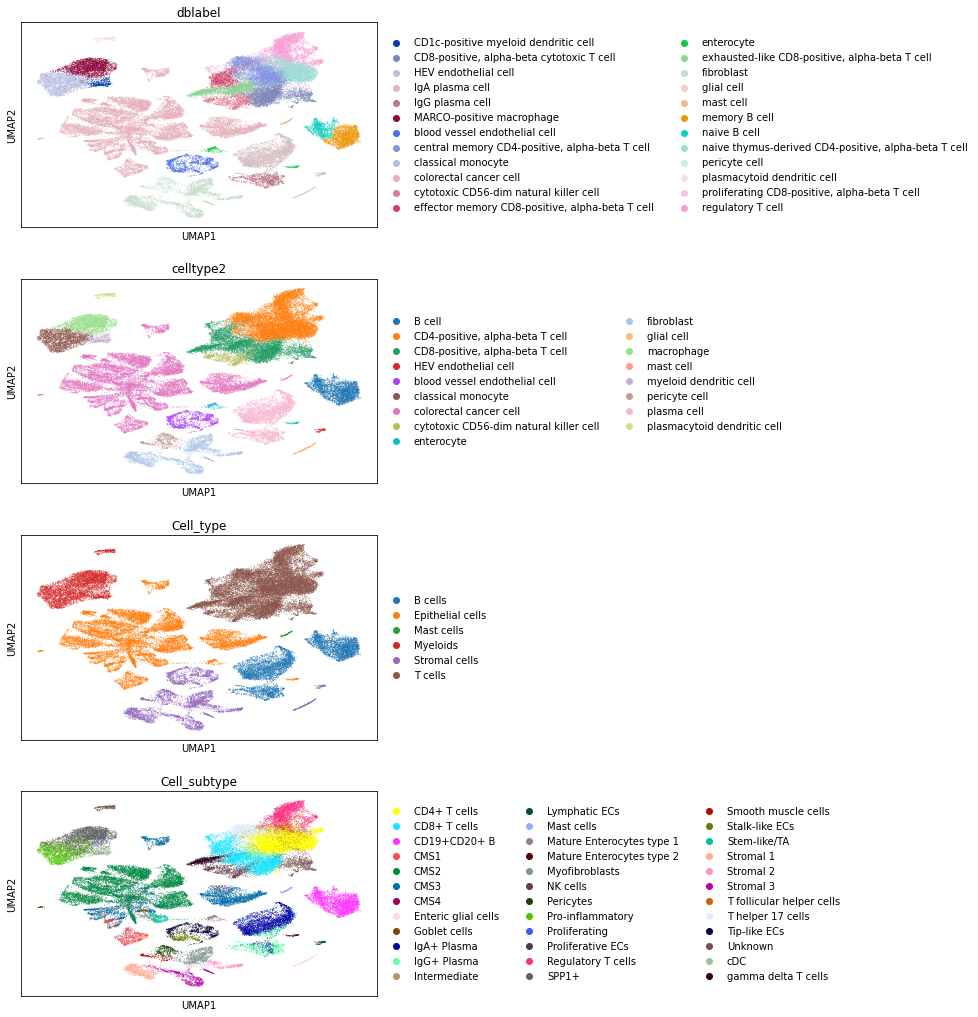

In [48]:
name = "Lee2020"
adata = bc.datasets.Lee2020_processed()
sc.pl.umap( adata, color = [ 'dblabel',  'celltype2', 'Cell_type', 'Cell_subtype'] , ncols=1)
#cluster = "assigned_cluster"
df = df.append( { 'Dataset' : name , 'value' : sklearn.metrics.silhouette_score(adata.obsm['X_umap'], adata.obs.get('dblabel')) , 'variable' : 'Score dblabel'} , ignore_index=True)
df = df.append( { 'Dataset' : name , 'value' : sklearn.metrics.silhouette_score(adata.obsm['X_umap'], adata.obs.get('celltype2')) , 'variable' : 'Score level 2'} , ignore_index=True)
df = df.append( { 'Dataset' : name , 'value' : sklearn.metrics.silhouette_score(adata.obsm['X_umap'], adata.obs.get('Cell_subtype')) , 'variable' : 'Score authors'} , ignore_index=True)

In [49]:
#sc.pl.umap( adata, color = [ 'dblabel', 'celltype3', 'celltype2', 'Cell_type', 'Cell_subtype'] , ncols=1)

adata.obs[ 'random_db']  = list(adata.obs['dblabel'].sample(frac=1))
df = df.append( { 'Dataset' : name , 'value' : sklearn.metrics.silhouette_score(adata.obsm['X_umap'], adata.obs.get('random_db')) , 'variable' : 'Score random'} , ignore_index=True)

## Plotting overall silhouette scores


Averaged silhouette scores shows overall a good consistency of the cell type annotation with the latent space captured in the UMAP projection (see figure below).  


In the case of PMB3K, the higher granularity silhouette score is slightly above 0.25. This dataset was annotated by reclustering (see Supplemental Figure S1) and specific markers with a low number of cells showing the difficulty already to decipher at a global resolution cell subtype. The coarser resolution leads to a high silhouette score.
The dataset from Kotliarov is also better on the level 2 annotation.

In the case of Granja, all annotations showed similar silhouette scores, this dataset is extremely rich in different cell-type.

Peng is discussed below.


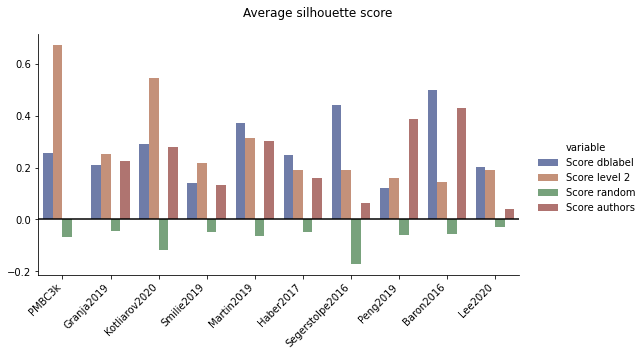

In [50]:
import matplotlib.pyplot as plt
g = sns.catplot(
    data=df, kind="bar",
    x="Dataset", y="value", hue="variable",
    ci="sd", palette="dark", alpha=.6,aspect = 1.5
)
g.set( ylabel='Average Silhouette coefficient')
g.set_xticklabels( rotation=45,
        horizontalalignment="right" )
g.fig.suptitle('Average silhouette score ')

g.map(plt.axhline, y=0, ls='-', c='black')

In [51]:
g.savefig( "figures/Averaged_scores.png", bbox_inches='tight')

In [52]:
g.savefig("figures/Averaged_scores.pdf", bbox_inches='tight')

# Exploration of PENG results

Below, we show that Peng  authors discriminate 2 subtype of ductal cells population and annotated at a coarser resolution than the dblabel assignation.

This is visible in the violin plots below. 

We can see that for besca annotation, ductal cells have a bad silhouette score, lowering the overall average. Peng could distinguish between two types of ductal cells; one being malignant.
This distinction was not made by the *sig_annot* module.

Also B cells are really well discriminated on the level 3 annotation (and individual cells have a high silhouette score) but we lose this high discrimination at the level 2 (B cells are spread out in different clusters), hence leading to bad score for the B cell cluster and lowering the overall average signature score.


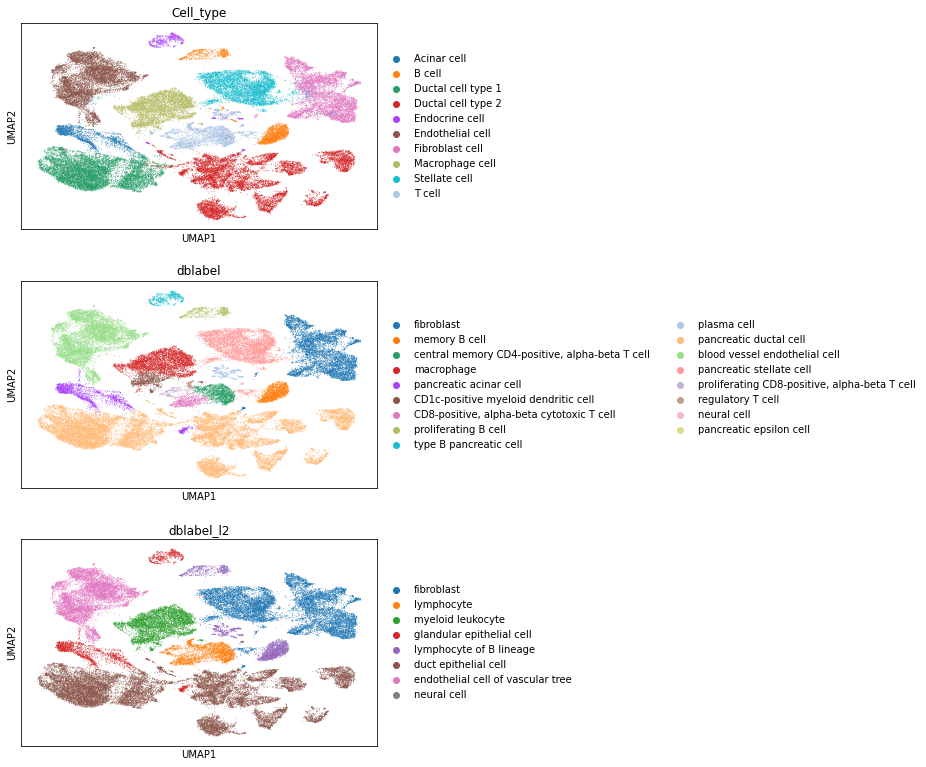

In [53]:
# Peng authors have really good results; why ? 
adata =  bc.datasets.Peng2019_processed()

adata = change_level(adata)
sc.pl.umap(adata, color = ["Cell_type", 'dblabel', 'dblabel_l2'], ncols = 1, save='Peng2019_umap.png')

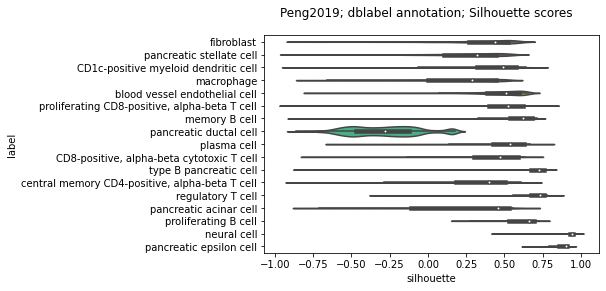

In [54]:
fig = result[ 'Peng2019'].dblabel_res.show_samples.get_figure()
fig.suptitle( 'Peng2019; dblabel annotation; Silhouette scores')
fig.savefig("figures/Peng_dblabel_silhouetteSamples.pdf", bbox_inches='tight')
fig

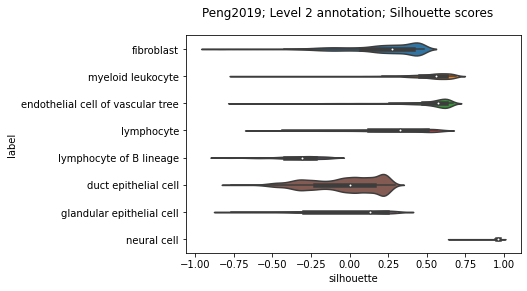

In [55]:
fig = result[ 'Peng2019'].dblabel_l2_res.show_samples.get_figure()
fig.suptitle('Peng2019; Level 2 annotation; Silhouette scores')
fig.savefig("figures/Peng_l2_silhouetteSamples.pdf", bbox_inches='tight')
fig

The average silhouette_score is : 0.3860819933658722


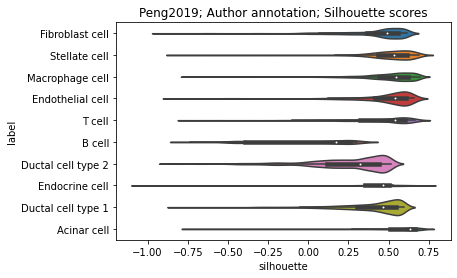

In [56]:
object_silhouette = silhouette_computation( adata, 'Cell_type')
fig = object_silhouette.show_samples.get_figure()
#fig


aa = object_silhouette.show_samples
aa.set_title( 'Peng2019; Author annotation; Silhouette scores')
fig = aa.get_figure()
fig.savefig("figures/Peng_authors_silhouetteSamples.pdf", bbox_inches='tight')
fig

# Lee 

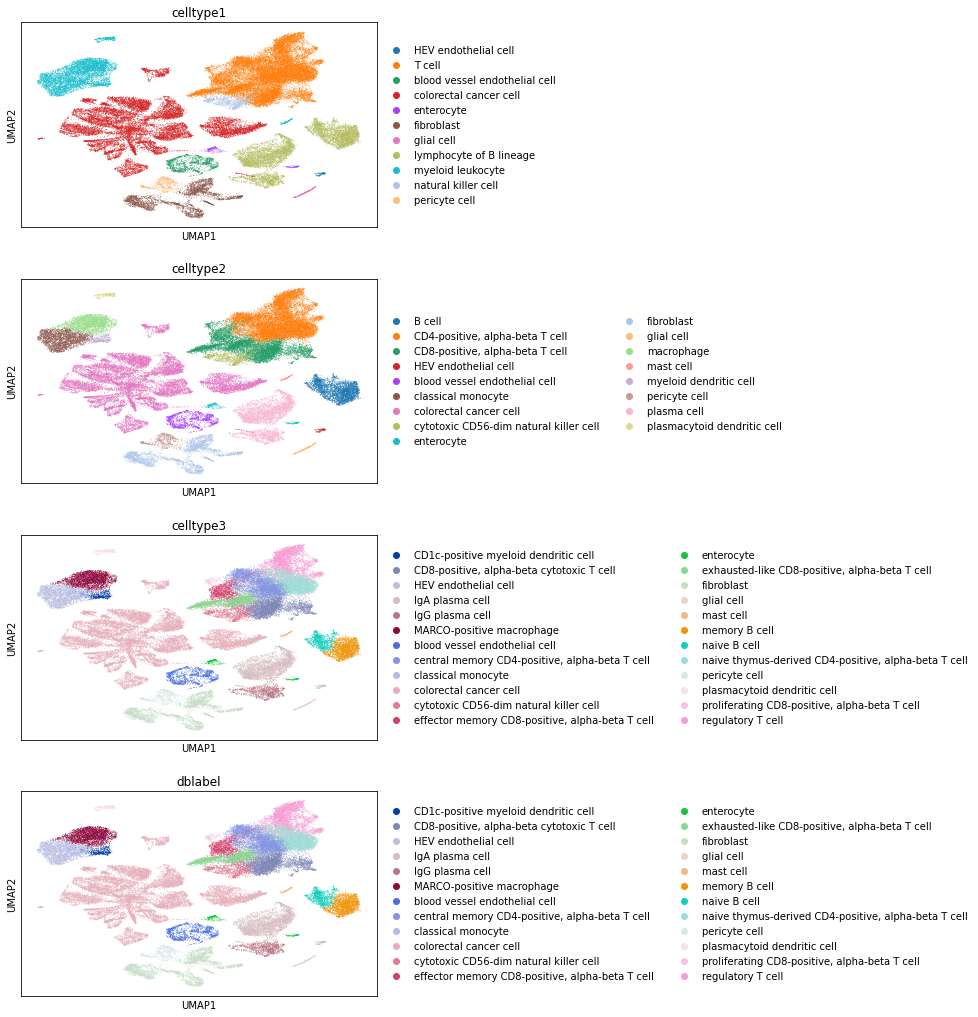

In [57]:

adata = bc.datasets.Lee2020_processed()
sc.pl.umap(adata, color = ['celltype1', 'celltype2', 'celltype3', 'dblabel'], ncols = 1, save='Lee2020_umap.png')

The average silhouette_score is : 0.20267852


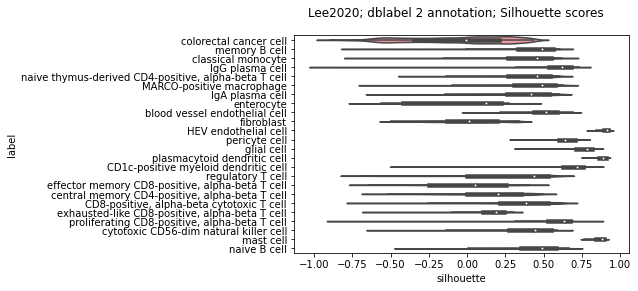

In [58]:

Lee_metrics_dblabel_l3 = silhouette_computation( adata)
fig = Lee_metrics_dblabel_l3.show_samples.get_figure()
fig.suptitle('Lee2020; dblabel 2 annotation; Silhouette scores')

fig.savefig("figures/Lee_dblabel_silhouetteSamples.pdf", bbox_inches='tight')
fig

The average silhouette_score is : 0.18985173


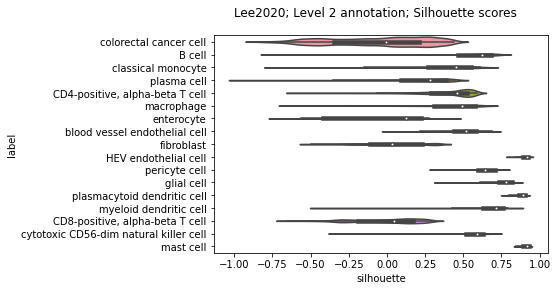

In [59]:

Lee_metrics_dblabel_l2 = silhouette_computation( adata, 'celltype2')
fig =Lee_metrics_dblabel_l2.show_samples.get_figure()
fig.suptitle('Lee2020; Level 2 annotation; Silhouette scores')
fig.savefig("figures/Lee_l2_silhouetteSamples.pdf", bbox_inches='tight')
fig

The average silhouette_score is : 0.17654343


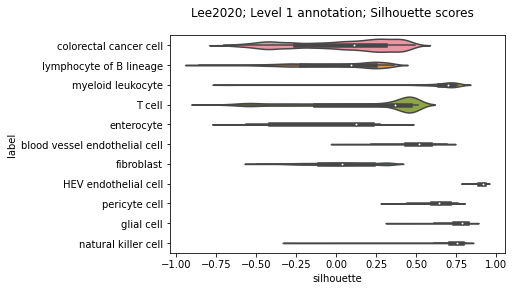

In [60]:

Lee_metrics_dblabel_l1 = silhouette_computation( adata, 'celltype1')
fig = Lee_metrics_dblabel_l1.show_samples.get_figure()
fig.suptitle('Lee2020; Level 1 annotation; Silhouette scores')
fig.savefig("figures/Lee_l1_silhouetteSamples.pdf", bbox_inches='tight')
fig

The average silhouette_score is : 0.040341124


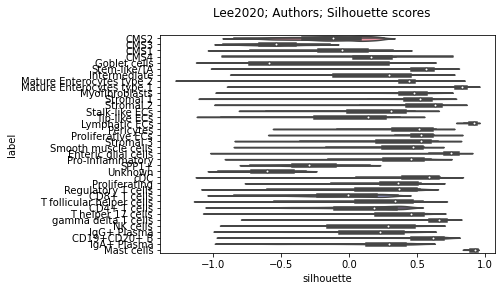

In [61]:
#'Cell_type', 'Cell_subtype'
Lee_metrics_authors = silhouette_computation( adata, 'Cell_subtype')
fig = Lee_metrics_authors.show_samples.get_figure()
fig.suptitle('Lee2020; Authors; Silhouette scores')
fig.savefig("figures/Lee_Authors_silhouetteSamples.pdf", bbox_inches='tight')
fig

# PBMC3K

In [62]:
result.keys()

dict_keys(['PMBC3k', 'Granja2019', 'Kotliarov2020', 'Smilie2019', 'Martin2019', 'Haber2017', 'Segerstolpe2016', 'Peng2019', 'Baron2016'])

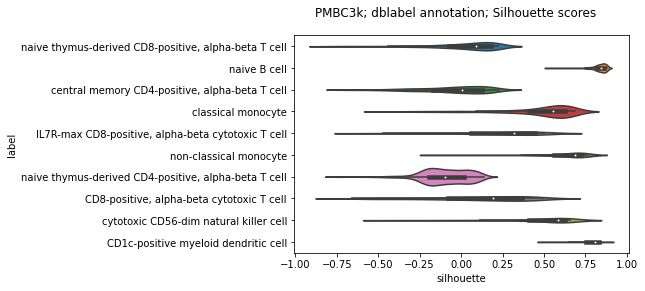

In [63]:
fig = result['PMBC3k'].dblabel_res.show_samples.get_figure()
fig.suptitle('PMBC3k; dblabel annotation; Silhouette scores')
fig.savefig("figures/PMBC3k_dblabel_silhouetteSamples.pdf", bbox_inches='tight')
fig

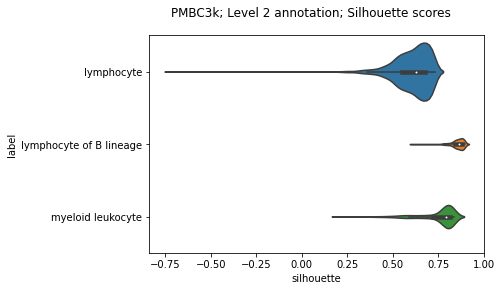

In [64]:
fig = result['PMBC3k'].dblabel_l2_res.show_samples.get_figure()
fig.suptitle('PMBC3k; Level 2 annotation; Silhouette scores')
fig.savefig("figures/PMBC3k_l2_silhouetteSamples.pdf", bbox_inches='tight')
fig

# Conclusion

## *sig-annot* scores overall

Overall, the silhouette scores showed that the *sig_annot* module annotation do capture as well as the authors and consistently the variability of cell presents and annotated in the datasets. 


## Silhouette learnings 

Looking at individual datasets, we notice that when we don't have yet a good granularity of the celltypes, in particular in cancer related datasets. For example Colorectal cancer cells in the data fromLee at al are numerous. They are thus divided into many clusters  and the average silhouette score can not render well the fact that one global type of cell is captured by many clusters. It makes sense as cancer cells will exhibit a large and diverse set of functions rendered in the transcriptomic space but were not annotated more specifically. Hence the silhouette here is not a good measure for *bio*similarity. 


However, specific clusters with really specific cells (such as mast cells) display a really good individual silhouette score; showing that the distinct clusters seen on the first 2 axis of the UMAP space is well distinguishable across the 50 axis of the embedded space.

Also when datasets are too much worked in depth such as pbmc3k, the silhouette score becomes lower pointing out to the fact that the cell identites becomes more about markers than clusters in the original dataset.





